# Final Project - Coursera


## Goal
 - This challenge serves as final project for the "How to win a data science competition" Coursera course.
 - In this competition you will work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. 
 - We are asking you to predict total sales for every product and store in the next month. By solving this competition you will be able to apply and enhance your data science skills.

# Load libraries

In [1]:
# Importando bibliotecas que serao utilizadas neste projeto
import pandas as pd
import numpy as np
import seaborn as sns
from itertools import product
from multiprocessing import Pool
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from multiprocessing import Pool

# Models
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from mlxtend.regressor import StackingCVRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import xgboost as xgb
from xgboost import plot_importance

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")

import pickle
import datetime
import time
import gc

/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# Import Data

In [2]:
DATA_FOLDER = 'data/origin/'

train           = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train_v2.csv'))
test            = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv')).set_index('ID')
items           = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shop            = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))
submission      = pd.read_csv(os.path.join(DATA_FOLDER, 'sample_submission.csv'))

# Part 1. EDA & Feature Engineering

In [3]:
print('Transactions: ', train.shape)
print('Test:', test.shape)
print('Items: ', items.shape)
print('Item Categories: ', item_categories.shape)
print('Shops:', shop.shape)

Transactions:  (2935849, 6)
Test: (214200, 2)
Items:  (22170, 3)
Item Categories:  (84, 2)
Shops: (60, 2)


In [4]:
shop.head()
shop.describe()
shop.shop_id.unique()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


,shop_id
count,60.000000
mean,29.500000
std,17.464249
min,0.000000
25%,14.750000
50%,29.500000
75%,44.250000
max,59.000000


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59])

In [5]:
item_categories.head()
item_categories.describe()
item_categories.item_category_id.unique()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


,item_category_id
count,84.000000
mean,41.500000
std,24.392622
min,0.000000
25%,20.750000
50%,41.500000
75%,62.250000
max,83.000000


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83])

In [6]:
items.head()
items.describe()
items.item_id.unique().shape[0]

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


,item_id,item_category_id
count,22170.00000,22170.000000
mean,11084.50000,46.290753
std,6400.07207,15.941486
min,0.00000,0.000000
25%,5542.25000,37.000000
50%,11084.50000,40.000000
75%,16626.75000,58.000000
max,22169.00000,83.000000


22170

In [7]:
test.head()
submission.head()

,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [8]:
train.head()
train.describe()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


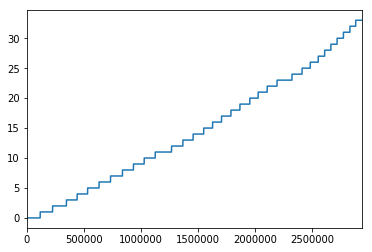

In [9]:
train.date_block_num.plot()

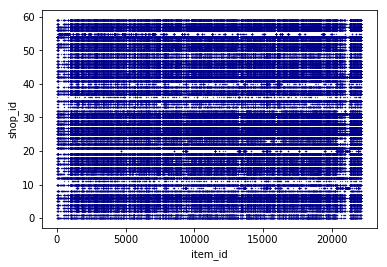

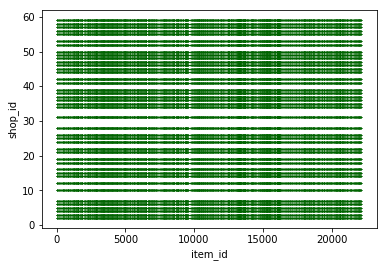

In [10]:
train.drop_duplicates(subset=['item_id', 'shop_id']).plot.scatter('item_id', 'shop_id', color='DarkBlue', s = 0.1)
test.drop_duplicates(subset=['item_id', 'shop_id']).plot.scatter('item_id', 'shop_id', color='DarkGreen', s = 0.1)

### Plot the feature distributions

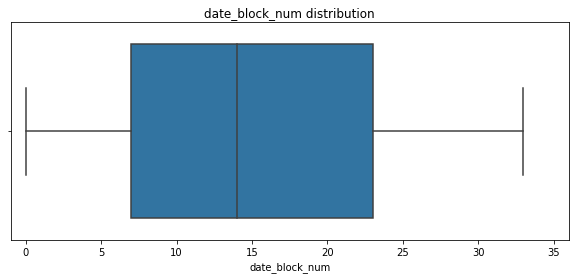

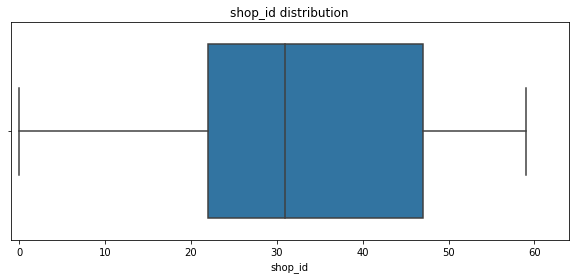

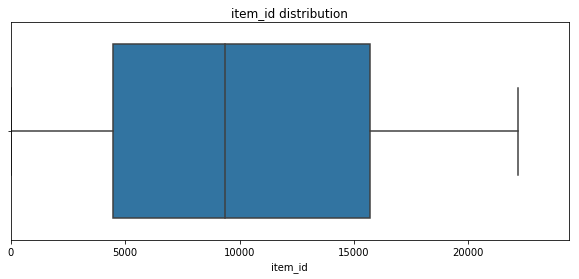

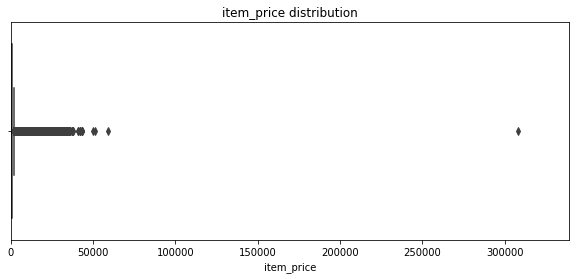

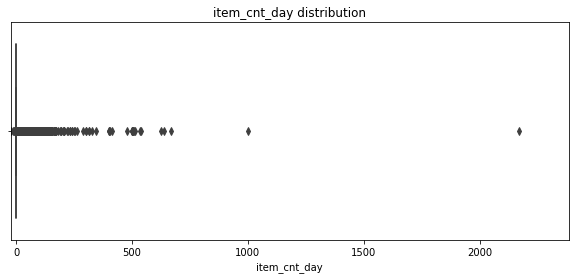

In [11]:
def box_plot(df,f):
    plt.figure(figsize=(10,4))
    plt.title(f+' distribution')
    x_min = int(df[f].min() - (abs(df[f].min())*0.1))
    x_max = int(df[f].max() + (abs(df[f].max())*0.1))
    if x_min==0:
        x_min = -1
    if x_max==0:
        x_max = 1
    plt.xlim(x_min,x_max)
    sns.boxplot(x=df[f])

plot_features = [x for x in train.columns.values if train[x].dtype != 'object']
for f in plot_features:
    box_plot(train,f)

### Outliers removal

In [12]:
test.merge(train, how='left', on=['shop_id', 'item_id']).isnull().sum()
test.shape[0]

shop_id                0
item_id                0
date              102796
date_block_num    102796
item_price        102796
item_cnt_day      102796
dtype: int64

214200

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,13.12.2013,11,12,6066,307980.0,1.0


,item_name,item_id,item_category_id
6066,Radmin 3 - 522 лиц.,6066,75


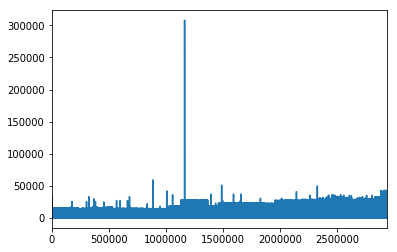

In [13]:
train.item_price.plot()
train[train['item_price'] > 100000]
items[items['item_id'] == 6066]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2326930,15.01.2015,24,12,20949,4.000000,1000.0
2909818,28.10.2015,33,12,11373,0.908714,2169.0


,item_name,item_id,item_category_id


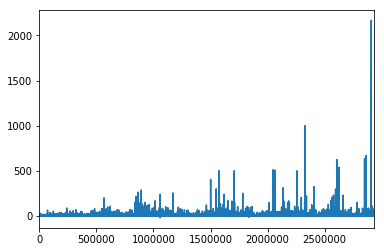

In [14]:
train.item_cnt_day.plot()
train[train['item_cnt_day'] > 900]
items[(items['item_id'] == 11373) & (items['item_id'] == 20949)]

In [15]:
train = train[train.item_price < 100000]
train = train[train.item_cnt_day <= 900]

## Aggregate Data

In [16]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

grid = []
for block_num in train['date_block_num'].unique():
    cur_shops = train.loc[train['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = train.loc[train['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

In [17]:
train_m = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': 'sum','item_price': np.mean}).reset_index()
train_m = pd.merge(grid,train_m,on=['date_block_num','shop_id','item_id'],how='left').fillna(0)

train_m = pd.merge(train_m,items,on=['item_id'],how='left')
train_m = pd.merge(train_m,item_categories, on=['item_category_id'], how='left')

## Mean encoding

In [18]:
for type_id in ['item_id','shop_id','item_category_id']:
    for column_id, agg_func, func_name in [('item_price',np.mean,'avg'),('item_cnt_day',np.sum,'sum'),('item_cnt_day',np.mean,'avg')]:

        mean_df = train_m.groupby([type_id,'date_block_num']).agg(agg_func).reset_index()[[column_id,type_id,'date_block_num']]
        mean_df.columns = [type_id+'_'+func_name+'_'+column_id, type_id,'date_block_num']
        
        train_m = pd.merge(train_m,mean_df,on=['date_block_num', type_id],how='left')

## Prepare test set

In [19]:
temp_test = test.copy()
temp_test['date_block_num'] = 34

temp_test = temp_test.merge(items, how='left', on='item_id')
temp_test = temp_test.merge(item_categories, how='left', on='item_category_id')
temp_test.drop('item_name', axis=1, inplace=True)

## Concat Train and Test

In [20]:
train_m.drop('item_name', axis=1, inplace=True)
train_m = pd.concat([train_m,temp_test], axis=0, ignore_index=True)

We create lags on 10 features. 9 features are from mean encoding and 1 feature is the item_cnt_day.

The month lag intervals of 1, 2, 3, 4, 5, 6, 9 and 12 give best score in the leaderboard.

In [21]:
lag_variables  = ['item_id_avg_item_price',
                  'item_id_sum_item_cnt_day',
                  'item_id_avg_item_cnt_day',
                  'shop_id_avg_item_price',
                  'shop_id_sum_item_cnt_day',
                  'shop_id_avg_item_cnt_day',
                  'item_category_id_avg_item_price',
                  'item_category_id_sum_item_cnt_day',
                  'item_category_id_avg_item_cnt_day',
                  'item_cnt_day']

lags = [1, 2, 3, 4, 5, 6, 9, 12]

for lag in lags:
    train_new_df = train_m.copy()
    train_new_df.date_block_num+=lag
    train_new_df = train_new_df[['date_block_num','shop_id','item_id']+lag_variables]
    train_new_df.columns = ['date_block_num','shop_id','item_id']+ [lag_feat+'_lag_'+str(lag) for lag_feat in lag_variables]
    train_m = train_m.merge(train_new_df,on=['date_block_num','shop_id','item_id'] ,how='left')

In [22]:
train_m.describe()

,date_block_num,item_category_id,item_category_id_avg_item_cnt_day,item_category_id_avg_item_price,item_category_id_sum_item_cnt_day,item_cnt_day,item_id,item_id_avg_item_cnt_day,item_id_avg_item_price,item_id_sum_item_cnt_day,...,item_id_avg_item_price_lag_12,item_id_sum_item_cnt_day_lag_12,item_id_avg_item_cnt_day_lag_12,shop_id_avg_item_price_lag_12,shop_id_sum_item_cnt_day_lag_12,shop_id_avg_item_cnt_day_lag_12,item_category_id_avg_item_price_lag_12,item_category_id_sum_item_cnt_day_lag_12,item_category_id_avg_item_cnt_day_lag_12,item_cnt_day_lag_12
count,1.112800e+07,1.112800e+07,1.091380e+07,1.091380e+07,1.091380e+07,1.091380e+07,1.112800e+07,1.091380e+07,1.091380e+07,1.091380e+07,...,3.120910e+06,3.120910e+06,3.120910e+06,3.120910e+06,3.120910e+06,3.120910e+06,3.120910e+06,3.120910e+06,3.120910e+06,3.120910e+06
mean,1.533960e+01,4.494398e+01,3.339840e-01,1.165793e+02,8.501853e+03,3.339840e-01,1.130371e+04,3.339840e-01,1.165793e+02,1.563816e+01,...,1.583253e+02,2.698094e+01,5.747183e-01,1.068854e+02,2.607527e+03,3.416632e-01,1.119120e+02,9.143684e+03,3.814021e-01,5.846160e-01
std,9.760412e+00,1.514000e+01,1.638930e+00,3.204530e+02,8.973476e+03,3.334923e+00,6.210934e+03,2.041781e+00,4.436281e+02,9.621956e+01,...,4.690863e+02,1.448749e+02,3.088144e+00,4.997387e+01,2.031522e+03,2.593814e-01,3.171460e+02,9.134180e+03,2.513105e+00,4.631928e+00
min,0.000000e+00,0.000000e+00,-2.272727e-02,2.600000e-01,-1.000000e+00,-2.200000e+01,0.000000e+00,-4.888889e-01,2.222222e-03,-2.200000e+01,...,2.666667e-02,-2.000000e+00,-4.444444e-02,2.329451e-02,2.000000e+00,3.025261e-04,1.038043e+00,2.000000e+00,1.923077e-02,-4.000000e+00
25%,7.000000e+00,3.700000e+01,1.578334e-01,2.973899e+01,1.077000e+03,0.000000e+00,5.947000e+03,3.921569e-02,9.652174e+00,2.000000e+00,...,2.128571e+01,4.000000e+00,8.000000e-02,7.603232e+01,1.419000e+03,1.947476e-01,2.986249e+01,1.204000e+03,1.761384e-01,0.000000e+00
50%,1.500000e+01,4.000000e+01,2.254803e-01,4.557390e+01,5.959000e+03,0.000000e+00,1.138800e+04,8.695652e-02,2.706250e+01,4.000000e+00,...,4.586957e+01,9.000000e+00,1.800000e-01,9.732444e+01,2.008000e+03,2.651934e-01,4.471525e+01,6.763000e+03,2.258126e-01,0.000000e+00
75%,2.300000e+01,5.500000e+01,2.876345e-01,1.110535e+02,1.283400e+04,0.000000e+00,1.659200e+04,2.391304e-01,7.740851e+01,1.100000e+01,...,1.226304e+02,2.000000e+01,4.222222e-01,1.257252e+02,2.875000e+03,3.644905e-01,1.066750e+02,1.361600e+04,2.876345e-01,0.000000e+00
max,3.400000e+01,8.300000e+01,2.729783e+02,2.255054e+04,3.627700e+04,1.644000e+03,2.216900e+04,2.729783e+02,2.408645e+04,1.255700e+04,...,2.255054e+04,1.255700e+04,2.729783e+02,3.474158e+02,1.631800e+04,1.925882e+00,2.255054e+04,3.627700e+04,2.729783e+02,1.305000e+03


### Create new time related features

### Missing values

In [23]:
for feat in train_m.columns:
    if 'item_cnt' in feat:
        train_m[feat]=train_m[feat].fillna(0)
    elif 'item_price' in feat:
        train_m[feat]=train_m[feat].fillna(train_m[feat].median())

### Drop columns and take data only after 12 since the most lag month interval is 12.

In [24]:
cols_to_drop = lag_variables[:-1] + ['item_price']
train_m = train_m[train_m['date_block_num'] > 12]

## Validation

We use holdout scheme for cross validation. We use sales month from 12 to 32 for training, month 33 for validation and month 34 for testing.

In [25]:
X_train = train_m[train_m['date_block_num'] < 33].drop(cols_to_drop, axis=1)
X_cv    = train_m[train_m['date_block_num'] ==33].drop(cols_to_drop, axis=1)
X_test  = train_m[train_m['date_block_num'] ==34].drop(cols_to_drop, axis=1)

## Reference from discussion

From discussion in Kaggle forum, we applied this useful trick, which clip the item_cnt_day within 40 instead of 20. In this way, there are more predictions on item_cnt_day = 20.

In [26]:
X_train['item_cnt_day'].clip_upper(40, inplace=True)
X_train['item_cnt_day'].clip_lower(0, inplace=True)

X_cv['item_cnt_day'].clip_upper(40, inplace=True)
X_cv['item_cnt_day'].clip_lower(0, inplace=True)

X_test['item_cnt_day'].clip_upper(40, inplace=True)
X_test['item_cnt_day'].clip_lower(0, inplace=True)

### Save files

In [ ]:
X_train.to_csv('data/files/X_train.csv', index=False)
X_cv.to_csv('data/files/X_cv.csv', index=False)
X_test.to_csv('data/files/X_test.csv', index=False)

# Part 2. Modelling

## 3 distinctively different models are used:

- Ridge Regression (Linear)
- LightGBM (Tree based)
- XGBoost (Tree based)
- After each model has been trained, a stacked ensemble model which the three models

### Data preparation

X_train = pd.read_csv('data/files/X_train.csv')
X_cv    = pd.read_csv('data/files/X_cv.csv')

In [27]:
cols = [c for c in X_train.columns if c not in ['item_category_name', 'date_block_num', 'item_cnt_day',]]

train_x = X_train[cols]
train_y = X_train['item_cnt_day']
val_x   = X_cv[cols]
val_y   = X_cv['item_cnt_day']

features = list(train_x.columns.values)

scoresRMSLE = {}

In [28]:
# Normalise data
scaler = preprocessing.StandardScaler()
scaler.fit(train_x.values)

train_x_norm = scaler.transform(train_x.values)
val_x_norm   = scaler.transform(val_x.values)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [29]:
def post_processing(model, model_name, train_x, train_y, val_x, val_y):
    train_pred = model.predict(train_x)
    val_pred   = model.predict(val_x)

    # Get rmse scores
    train_rmse = np.sqrt(mean_squared_error(train_y, train_pred))
    print("Train RMSE: %f" % (train_rmse))
    val_rmse = np.sqrt(mean_squared_error(val_y, val_pred))
    print("Val RMSE: %f" % (val_rmse))

    scoresRMSLE[model_name] = (train_rmse, val_rmse)
    
    return train_pred,val_pred

In [30]:
def plot_feature_importances(importances,indices,features,title,dimensions):
    plt.figure(figsize=dimensions)
    plt.title(title)
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()   

## Ridge Regression

In [31]:
# Training
gc.collect()
ts = time.time()

lm = linear_model.Ridge()
lm.fit(train_x_norm, train_y)
print ('Training time: %s' %(time.time() - ts))

17429

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Training time: 6.286525249481201


In [32]:
# Performance and test predictions
train_pred1, val_pred1 = post_processing(lm, 'Rigde',
                                         train_x_norm, train_y,
                                         val_x_norm, val_y)

Train RMSE: 1.231579
Val RMSE: 1.248318


## LightGBM

In [33]:
# Training
gc.collect()
ts = time.time()

# Light Gradient Boosting Regressor
lightgbm = LGBMRegressor()
lightgbm.fit(train_x_norm, train_y)

print ('Training time: %s' %(time.time() - ts))

70

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

Training time: 57.08978080749512


In [34]:
# Performance and test predictions
train_pred2, val_pred2 = post_processing(lightgbm, 'lightgbm',
                                         train_x_norm, train_y,
                                         val_x_norm, val_y)

Train RMSE: 0.989966
Val RMSE: 1.167470


## XGBoost

In [35]:
# Training
gc.collect()
ts = time.time()

xgbtrain = xgb.DMatrix(train_x.values, train_y.values)

params = {'max_depth':10, 
         'subsample':1,
         'min_child_weight':0.5,
         'eta':0.08, 
         'num_round':1000, 
         'seed':3,
         'silent':True,
         'eval_metric':'rmse'}

bst = xgb.train(params, xgbtrain)
print ('Training time: %s' %(time.time() - ts))

131

Training time: 1353.680524110794


In [36]:
# Performance and test predictions
train_pred3, val_pred3 = post_processing(bst, 'xgboost',
                                         xgb.DMatrix(train_x.values), train_y,
                                         xgb.DMatrix(val_x.values), val_y)

Train RMSE: 1.126010
Val RMSE: 1.183770


<Figure size 576x1152 with 0 Axes>

Text(0.5, 1.0, 'XGBoost Feature Importances')

<BarContainer object of 83 artists>

([<matplotlib.axis.YTick at 0x1a1d5f56d8>,
 <a list of 83 Text yticklabel objects>)

Text(0.5, 0, 'Relative Importance')

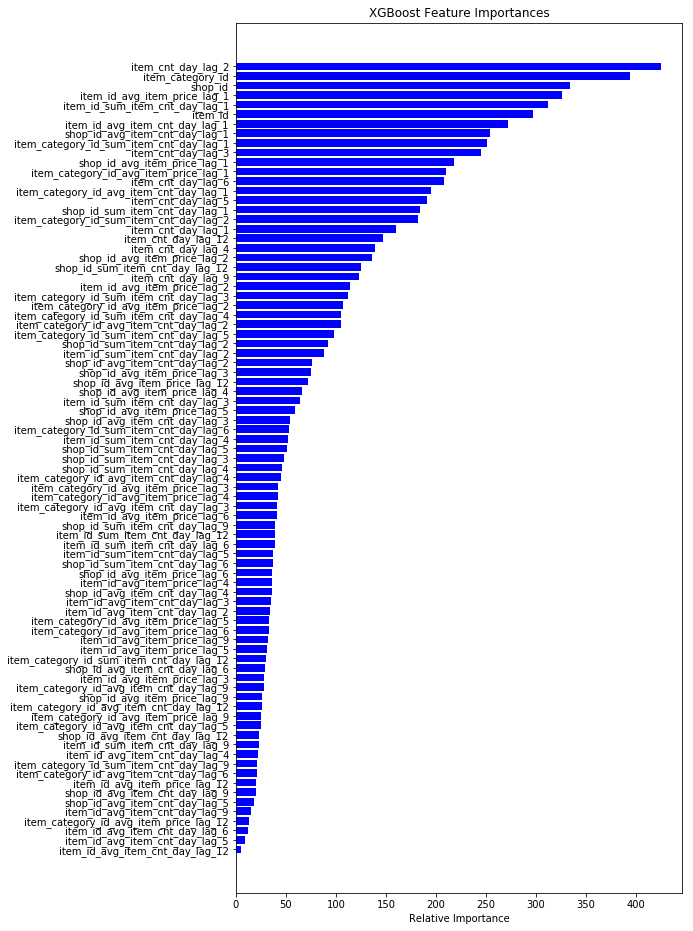

In [37]:
# Feature Importance
import operator
importance = sorted(bst.get_score().items(), key=operator.itemgetter(1))
importance_v = np.asarray([x[1] for x in importance],dtype=np.int16)
indices = np.asarray([int(x[0].replace('f','')) for x in importance],dtype=np.int8)
title = 'XGBoost Feature Importances'

plt.figure(figsize=(8,16))
plt.title(title)
plt.barh(range(len(indices)), importance_v, color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## StackingCVRegressor

In [38]:
# Training
gc.collect()
ts = time.time()

xgboost = XGBRegressor(objective='reg:squarederror')

# Stack up all the models above, optimized using xgboost
stack_gen = StackingCVRegressor(regressors=(lm, lightgbm, xgboost),
                                meta_regressor=xgboost,
                                random_state=3,
                                use_features_in_secondary=True)

stack_gen.fit(train_x_norm, train_y)
print ('Training time: %s' %(time.time() - ts))

65

[00:16:43] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[01:25:18] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[02:34:12] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[03:42:06] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[04:50:25] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_meth

StackingCVRegressor(cv=5,
          meta_regressor=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1),
          n_jobs=None, pre_dispatch='2*n_jobs', random_state=3, refit=True,
          regressors=(Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001), LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_chil...alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1)),
     

Training time: 34059.8013176918


In [39]:
# Performance and test predictions
train_pred4, val_pred4 = post_processing(stack_gen, 'stack_gen',
                                         train_x_norm, train_y,
                                         val_x_norm, val_y)

Train RMSE: 1.047410
Val RMSE: 1.149655


## Results

In [40]:
print(scoresRMSLE)

{'Rigde': (1.231578561708175, 1.2483180790370727), 'lightgbm': (0.9899664623803331, 1.1674700513107692), 'xgboost': (1.126010212578711, 1.1837702966334356), 'stack_gen': (1.0474103258865044, 1.1496551581200345)}


Text(0, 1.231578561708175, '1.2316')

Text(1, 0.9899664623803331, '0.9900')

Text(2, 1.126010212578711, '1.1260')

Text(3, 1.0474103258865044, '1.0474')

Text(0, 0.5, 'Score (RMSE)')

Text(0.5, 0, 'Algoritmos de Machine Learning')

Text(0.5, 1.0, 'Scores dos Modelos (RMSE)')

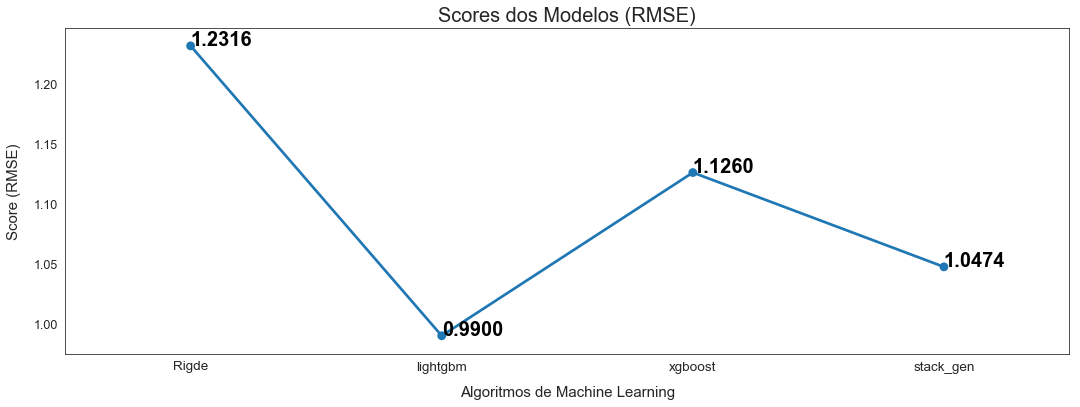

In [41]:
# Plot models performance
sns.set_style("white")
fig = plt.figure(figsize=(18, 6))

ax = sns.pointplot(x=list(scoresRMSLE.keys()), y=[resRMSE for resRMSE, _ in scoresRMSLE.values()], markers=['o'], linestyles=['-'])
for i, resRMSE in enumerate(scoresRMSLE.values()):
    ax.text(i, resRMSE[0] , '{:.4f}'.format(resRMSE[0]), horizontalalignment='left', color='black', weight='semibold', size='20')

plt.ylabel('Score (RMSE)', size=15, labelpad=12.5)
plt.xlabel('Algoritmos de Machine Learning', size=15, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores dos Modelos (RMSE)', size=20)

plt.show()

## Save best model in validation dataset and make predictions and submission

In [42]:
gc.collect()
pickle.dump(stack_gen, open("data/model/stack_gen_model.dat", "wb"))

69

In [52]:
# Open model
model = pickle.load(open("data/model/stack_gen_model.dat", "rb"))
model

StackingCVRegressor(cv=5,
          meta_regressor=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=nan, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1),
          n_jobs=None, pre_dispatch='2*n_jobs', random_state=3, refit=True,
          regressors=(Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001), LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_chil...alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1)),
      

In [61]:
# Load dataset Test
test   = pd.read_csv('data/origin/test.csv')

In [62]:
cols = [c for c in X_train.columns if c not in ['item_category_name', 'date_block_num', 'item_cnt_day',]]

test_x = X_test[cols]

In [63]:
# Normalise data
scaler = preprocessing.StandardScaler()
scaler.fit(test_x.values)

test_x_norm = scaler.transform(test_x.values)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [64]:
# Predictions and submission
pred = model.predict(test_x_norm)

test['item_cnt_month'] = pred.clip(0,40)
test.drop(['shop_id', 'item_id'], axis=1, inplace=True)
test.to_csv('data/submission/submission_final.csv', index=False)